<a href="https://colab.research.google.com/github/secutron/TesTime/blob/main/diffusers/02_guideline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q diffusers transformers xformers git+https://github.com/huggingface/accelerate.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 120.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.7 MB/s eta 0:00:00


<ipython-input-2-b3833ce7e868>:41: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/25 [00:00<?, ?it/s]

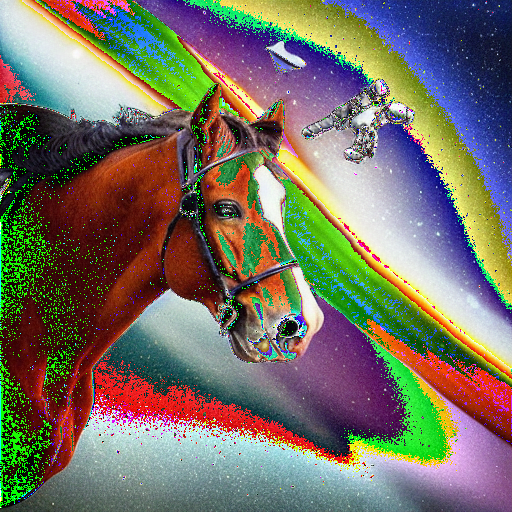

In [2]:
import torch
from PIL import Image
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import UniPCMultistepScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

prompt = ["a photograph of an astronaut riding a horse"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(0)  # Seed generator to create the inital latent noise
batch_size = len(prompt)

text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)

latents = latents * scheduler.init_noise_sigma

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample


# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0] 